**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4034 - Análisis de grandes volúmenes de datos (Gpo 10)**

Tecnológico de Monterrey

Dr. Nestor Velasco Bermeo

**Semana 8 **
8.2 Avance de proyecto 4: Comparación de Sistemas de Recomendación
---


*   NOMBRE: Luis Salomon Flores Ugalde
*   MATRÍCULA: A00817435
*   NOMBRE: Alejandro Guzmán Chávez
*   MATRÍCULA: A01795398
*   NOMBRE: Oscar Israel Lerma Franco
*   MATRÍCULA: A01380817

En esta entrega es necesario realizar un reporte donde se enlisten los siguientes aspectos:

* Revisión del alcance y objetivos del proyecto. Discute y analiza con tus compañeros de equipo cualquier modificación requerida para ajustes al alcance u objetivos del proyecto. Documenta los cambios si los hay, en caso contrario, escribe sin cambios en este rubro.
* Realiza la comparación de diferentes algoritmos de recomendación de las actividades 4.2 y 6.2, en términos de rendimiento y escalabilidad. Crea una tabla que demuestre la evidencia de la comparación. 

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import json
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import time

In [141]:
import os

print("Current working directory:", os.getcwd())


Current working directory: /home/olerma/Desktop/maestria/bigdata/MNA_GVD24


## Utility functions

```python 
import re
import json

def read_lines(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        while True:
            line = file.readline()
            if not line:
                break
            data.append(line)
    return data

def parse(g):
   for l in g:
        yield eval(l)

def parse_dataload_to_json_list(data):
    parsed = []
    line_count = 0
    for l in parse(data):
        line_count += 1
        r = json.dumps(l)
        loaded_r = json.loads(r)
        parsed.append(loaded_r)
    return parsed
```

## Lectura y transformación de los archivos en DataFrames

```python 
data_games = read_lines('steam_games.json')
json_games = parse_dataload_to_json_list(data_games)
with open('steam_games_p3.json', 'w', encoding='utf-8') as f:
    for item in json_games:
        json.dump(item, f, ensure_ascii=False)
        f.write('\n')
``` 

In [146]:
steam_games_df = pd.read_json('steam_games_p3.json', lines=True)

steam_games_df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,NaN,NaN,NaN


Repetimos para las reviews de usuarios australianos.

```python 
data_aus_rev = read_lines('australian_user_reviews.json')
json_aus_rev = parse_dataload_to_json_list(data_aus_rev)
with open('steam_aus_rev_p3.json', 'w', encoding='utf-8') as f:
    for item in json_aus_rev:
        json.dump(item, f, ensure_ascii=False)
        f.write('\n')
```

In [149]:
steam_aus_rev_df = pd.read_json('steam_aus_rev_p3.json', lines=True)

steam_aus_rev_df.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [150]:
working_df = steam_aus_rev_df.explode('reviews')
reviews_df = pd.json_normalize(working_df['reviews'])
reviews_df = reviews_df.join(working_df[['user_id', 'user_url']].reset_index(drop=True))

In [151]:
reviews_df

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id,user_url
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637,http://steamcommunity.com/id/js41637
...,...,...,...,...,...,...,...,...,...
59328,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...,76561198312638244,http://steamcommunity.com/profiles/76561198312...
59329,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...,76561198312638244,http://steamcommunity.com/profiles/76561198312...
59330,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...,LydiaMorley,http://steamcommunity.com/id/LydiaMorley
59331,,Posted July 20.,,730,No ratings yet,True,:D,LydiaMorley,http://steamcommunity.com/id/LydiaMorley


### Repitiendo pasos de avance 1 y 2

In [153]:
steam_games_df = steam_games_df.drop(columns=['metascore'],axis=1)

In [154]:
steam_games_df['publisher'].fillna('', inplace=True)
steam_games_df['genres'].fillna('[]', inplace=True) #Usamos una lista vacías ya que es el formato de la columna y permitirá separarla después
steam_games_df['tags'].fillna('[]', inplace=True) #Usamos una lista vacías ya que es el formato de la columna y permitirá separarla después

## Preprocesamiento

In [156]:
reviews_df = reviews_df.dropna(subset=['recommend'])
assert reviews_df['recommend'].isna().sum() == 0
reviews_df['recommend'] = reviews_df['recommend'].astype(int)

/tmp/ipykernel_7091/1596073169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['recommend'] = reviews_df['recommend'].astype(int)


In [157]:
#steam_games_df = steam_games_df.dropna(subset=['id'])
steam_games_df = steam_games_df[steam_games_df['id'].notna()]
steam_games_df.reset_index(drop=True, inplace=True)


In [158]:
steam_games_df['id'] = steam_games_df['id'].astype(int)
#steam_games_df['id'] = steam_games_df['id'].astype(str).str.replace('.0', '', regex=False)

In [159]:
#reviews_df = reviews_df.dropna(subset=['item_id'])
reviews_df = reviews_df[reviews_df['item_id'].notna()]
reviews_df.reset_index(drop=True, inplace=True)
reviews_df['item_id'] = reviews_df['item_id'].astype(int)
reviews_df = reviews_df[reviews_df['item_id'].isin(steam_games_df['id'])]
reviews_df = reviews_df.drop(columns=['funny', 'posted', 'last_edited', 'helpful', 'user_url'], axis=1)

Contamos los generos y los tags, ya que son las características que ayudarán a encontrar similitudes

In [161]:
from collections import Counter

contador_generos = Counter(g for genres in steam_games_df['genres'] for g in genres)
contador_tags = Counter(t for tags in steam_games_df['tags'] for t in tags)

## Transformado de datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen los juegos de steam y las columnas las caracteristicas (generos y tags)


In [164]:
genres = list(contador_generos.keys())

for g in genres:
    steam_games_df[g] = steam_games_df['genres'].transform(lambda x: int(g in x))

In [165]:
steam_games_df[genres].head()

,Action,Casual,Indie,Simulation,Strategy,Free to Play,RPG,Sports,Adventure,[,...,Animation &amp; Modeling,Video Production,Utilities,Web Publishing,Education,Software Training,Design &amp; Illustration,Audio Production,Photo Editing,Accounting
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Para codificar los tags usaremos otro algoritmo para mejorar el rendimiento ya que son muchos tags

In [167]:
tags = list(contador_tags.keys())

tags_matrix = {tag: steam_games_df['tags'].apply(lambda x: int(tag in x)) for tag in contador_tags.keys()}
tags_df = pd.DataFrame(tags_matrix)
steam_features = pd.concat([steam_games_df[genres], tags_df], axis=1)

steam_features.head()

,Action,Casual,Indie,Simulation,Strategy,Free to Play,RPG,Sports,Adventure,[,...,Foreign,Feature Film,Hardware,Steam Machine,Philisophical,Mystery Dungeon,Wrestling,360 Video,Faith,Bikes
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Algoritmo de recomendación Similaridad de Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{juego}}, n_{\text{juego}})$. Esta matriz nos permitira extraer juegos que sean parecidos al videojuego de interes.

In [170]:
from sklearn.metrics.pairwise import cosine_similarity
start_time_cosine_sim = time.time()
cosine_sim = cosine_similarity(steam_features, steam_features)
end_time_cosine_sim = time.time()
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (32133, 32133)


Ahora generamos un método que devuelva las recomendaciones para un usuario específico

In [172]:
game_idx = dict(zip(steam_games_df['id'], list(steam_games_df.index)))


In [173]:
def encuentra_juego(game_id):
    title = steam_games_df[steam_games_df['id'] == game_id]['title'].iloc[0]
    return title

In [174]:
def obtener_recomendaciones_basadas_contenido(game_id, numero_recomendaciones=10):
    title = encuentra_juego(game_id)
    idx = game_idx[game_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_games = [i[0] for i in sim_scores]
    print(f"Porque te gustó {title} te pueden gustar:")
    print(steam_games_df['title'].iloc[similar_games])

## Algoritmo de recomendación SVD basico

Repitiendo pasos de avance 1

In [177]:
reviews_svd_df = reviews_df[['user_id', 'review', 'recommend','item_id']]

In [178]:
start_time_svd_basic = time.time()
UtAus_review = reviews_svd_df.pivot_table(values='recommend', index='item_id', columns='user_id', fill_value=0).astype(float)
print('(juego, usuarios) =', (UtAus_review.shape))
UtAus_review.head()

(juego, usuarios) = (3195, 24380)


user_id,--000--,--ace--,--ionex--,-2SV-vuLB-Kg,-Azsael-,-Beave-,-I_AM_EPIC-,-Kenny,-Mad-,-PRoSlayeR-,...,zuilde,zukuta,zunbae,zuzuga2003,zv_odd,zvanik,zwanzigdrei,zy0705,zynxgameth,zyr0n1c
item_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
sparse_matrix_svd = csr_matrix(UtAus_review.values)

U, sigma, VT = svds(sparse_matrix_svd, k=450)  

sigma = np.diag(sigma)

# Compute the dot product to get the approximated original matrix
predicted_ratings = np.dot(np.dot(U, sigma), VT)

# Converting the reconstructed matrix back to a DataFrame
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=UtAus_review.index, columns=UtAus_review.columns)

In [180]:
actual_ratings = UtAus_review.values.flatten()
predicted_ratings = predicted_ratings_df.values.flatten()

# Only consider non-zero elements
mask = actual_ratings > 0
actual_ratings = actual_ratings[mask]
predicted_ratings = predicted_ratings[mask]
end_time_svd_basic = time.time()

# Calculate RMSE
rmse = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print("RMSE:", rmse)

RMSE: 0.3505428989509815


In [181]:
def recommend_items_svd(user_id, original_matrix, predictions_df, num_recommendations=5):
    user_col_number = original_matrix.columns.get_loc(user_id)    
    sorted_user_predictions = predictions_df.iloc[:, user_col_number].sort_values(ascending=False)
    #print(sorted_user_predictions)
    user_data = original_matrix[user_id]
    #print(user_data[user_data != 0].index)
    return sorted_user_predictions.drop(user_data[user_data != 0].index).head(num_recommendations)
    # return recommendations.head(num_recommendations)

## Algoritmo Recomendación de K-means

Para crear un sistema de recomendación K-means en Python que recomiende juegos basándose en sus títulos, podemos utilizar las etiquetas o géneros del conjunto de datos para representar cada juego. Así es como puedes hacerlo
* **Preprocesar los datos**: Extrae las características relevantes del conjunto de datos (En nuestro caso titulo, etiquetas y generos).
* **Vectorizar las características**: Convertir los datos categóricos (etiquetas, géneros) en vectores numéricos.
* **Aplicar la agrupación de K-means**: Agrupar los juegos en función de estos vectores, en este caso utilizando el metodo del codo.
* **Crear una función de recomendación**: Encontrar los juegos más cercanos en el mismo clúster para las recomendaciones.

In [361]:
reviews_kmeans_df = steam_games_df[['app_name', 'tags', 'genres']].copy()

# Funcion 'segura' para transformacion de str a listas
def safe_literal_eval(val):
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

# Convertir etiquetas y géneros de cadena a lista
reviews_kmeans_df['tags'] = reviews_kmeans_df['tags'].apply(lambda x: safe_literal_eval(x) if isinstance(x, (str, list)) else [])
reviews_kmeans_df['genres'] = reviews_kmeans_df['genres'].apply(lambda x: safe_literal_eval(x) if isinstance(x, (str, list)) else [])

# Combinar etiquetas y géneros para vectorizar
reviews_kmeans_df['features'] = reviews_kmeans_df['tags'] + reviews_kmeans_df['genres']



In [363]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

# Inicializar MultiLabelBinarizer
mlb = MultiLabelBinarizer()
features_matrix = mlb.fit_transform(reviews_kmeans_df['features'])

# Crear DataFrame con las features combinadas
features_df = pd.DataFrame(features_matrix, columns=mlb.classes_)


## Cálculo del método del codo:
El método del codo es una técnica común utilizada para determinar el número óptimo de conglomerados para la agrupación K-means. 

Consiste en:

* Ejecutar el clustering K-means para un rango de números de cluster (1 a max_clusters, definido como 30).
* Guardar la suma de cuadrados dentro del cluster (WCSS) para cada número de clusters.
* Trazar el gráfico de codo graficando los valores WCSS contra el número de clusters.
* El punto "codo" (el mas acercado al origen ó el que aparentemente "divida") del gráfico indica el número óptimo de clusters.
* Ejecutar la agrupación K-means con el número de conglomerados elegido.

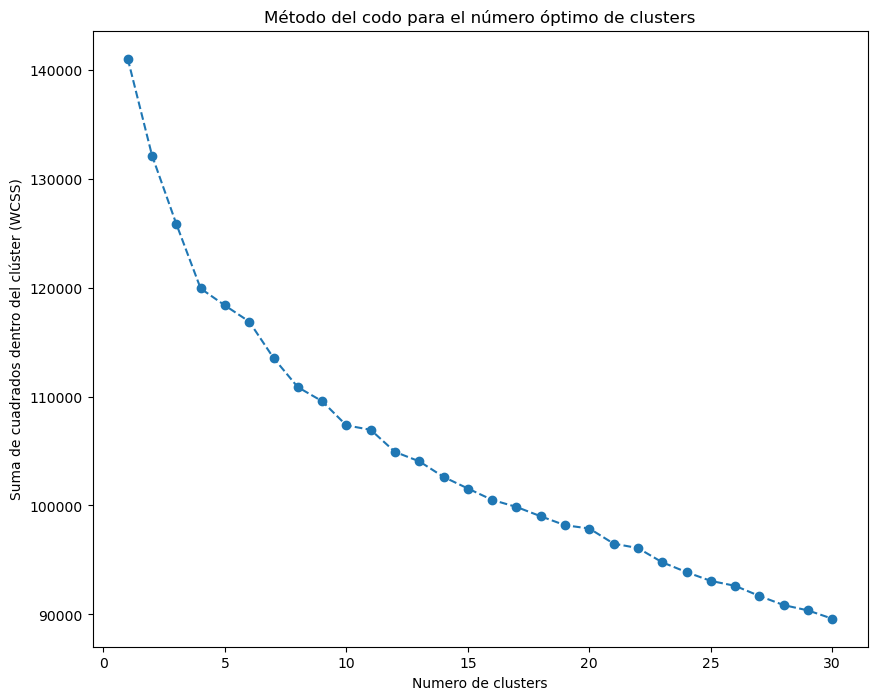

In [366]:
# Método del codo para hallar el número óptimo de custers
wcss = []
max_clusters = 30   

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_df)
    wcss.append(kmeans.inertia_)

# Traza el gráfico del método del codo
plt.figure(figsize=(10, 8))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Método del codo para el número óptimo de clusters')
plt.xlabel('Numero de clusters')
plt.ylabel('Suma de cuadrados dentro del clúster (WCSS)')
plt.show()

In [368]:
from sklearn.cluster import KMeans

# Aplicar K-means clusterizacion basado en el metodo del codo
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=1)
reviews_kmeans_df['cluster'] = kmeans.fit_predict(features_df)

In [382]:
def recommend_games_kmeans(title, reviews_kmeans_df, num_recommendations=5):
    # Encuentrar el cluster del título del juego dado
    cluster = reviews_kmeans_df[reviews_kmeans_df['app_name'] == title]['cluster'].values[0]
    
    # Buscar otros juegos en el mismo cluster
    similar_games = reviews_kmeans_df[reviews_kmeans_df['cluster'] == cluster]
    
    # Excluir el juego de entrada de las recomendaciones
    recommendations = similar_games[similar_games['app_name'] != title]
    
    return recommendations['app_name'].head(num_recommendations)

## Recomendaciones SVD

In [74]:
user_id = 'LydiaMorley' 
recommendations = recommend_items_svd(user_id, UtAus_review, predicted_ratings_df)

recommendations_df = pd.DataFrame(recommendations).reset_index()
recommendations_df.columns = ['item_id', 'predicted_rating']
merged_df = recommendations_df.merge(steam_games_df, left_on='item_id', right_on='id', how='left')
merged_df

,item_id,predicted_rating,publisher,genres,app_name,title,url,release_date,tags,discount_price,...,Animation &amp; Modeling,Video Production,Utilities,Web Publishing,Education,Software Training,Design &amp; Illustration,Audio Production,Photo Editing,Accounting
0,200170,0.044101,Team17 Digital Ltd,[Strategy],Worms Revolution,Worms Revolution,http://store.steampowered.com/app/200170/Worms...,2012-10-10,"[Strategy, Multiplayer, Funny, Turn-Based Stra...",NaN,...,0,0,0,0,0,0,0,0,0,0
1,17510,0.043667,,[Indie],Age of Chivalry,Age of Chivalry,http://store.steampowered.com/app/17510/Age_of...,2007-12-01,"[Indie, Free to Play, Medieval, Mod, Action, M...",NaN,...,0,0,0,0,0,0,0,0,0,0
2,413410,0.041808,"Spike Chunsoft Co., Ltd.",[Adventure],Danganronpa: Trigger Happy Havoc,Danganronpa: Trigger Happy Havoc,http://store.steampowered.com/app/413410/Danga...,2016-02-18,"[Anime, Mystery, Visual Novel, Detective, Stor...",NaN,...,0,0,0,0,0,0,0,0,0,0
3,349480,0.038164,Steam Greenlight,"[Action, Free to Play, RPG]",Modular Combat,Modular Combat,http://store.steampowered.com/app/349480/Modul...,2008-01-18,"[Free to Play, Multiplayer, Action, Mod, FPS, ...",NaN,...,0,0,0,0,0,0,0,0,0,0
4,102700,0.036182,En Masse Entertainment,"[Action, Free to Play]",A.V.A. Alliance of Valiant Arms™,A.V.A. Alliance of Valiant Arms™,http://store.steampowered.com/app/102700/AVA_A...,2011-06-14,"[Free to Play, FPS, Action, Multiplayer, Shoot...",NaN,...,0,0,0,0,0,0,0,0,0,0


## Recomendaciones Cosine

In [76]:
for index,row in reviews_df.head().iterrows():
  print(f'\nRecomendaciones para el usuario: {row["user_id"]}')
  obtener_recomendaciones_basadas_contenido(row['item_id'],5)


Recomendaciones para el usuario: 76561197970982479
Porque te gustó Killing Floor te pueden gustar:
7987                                       Killing Floor 2
31527                                        Left 4 Dead 2
31753                           Call of Duty: World at War
31752                                          Left 4 Dead
1380     Resident Evil Revelations / Biohazard Revelations
Name: title, dtype: object

Recomendaciones para el usuario: 76561197970982479
Porque te gustó Zeno Clash te pueden gustar:
30194    Zeno Clash 2
25058      Orc Slayer
26728         Despair
6581          WARZONE
1850       CONSORTIUM
Name: title, dtype: object

Recomendaciones para el usuario: js41637
Porque te gustó Euro Truck Simulator 2 te pueden gustar:
30303                    Euro Truck Simulator
24194                American Truck Simulator
26714    Euro Truck Simulator 2 - Scandinavia
14744                               Real Farm
5844                                   Jalopy
Name: title, dt

## Recomendaciones K Means

In [406]:
for index,row in reviews_kmeans_df.head().iterrows():
    recommendations = recommend_games_kmeans(row["app_name"], reviews_kmeans_df)
    print(f"Juegos Similares a: '{row['app_name']}':\n\n {recommendations}\n")

Juegos Similares a: 'Lost Summoner Kitty':

 4                                         Log Challenge
10                                      Uncanny Islands
12    Army of Tentacles: (Not) A Cthulhu Dating Sim:...
20                                           Kitty Hawk
21                             The Warrior Of Treasures
Name: app_name, dtype: object

Juegos Similares a: 'Ironbound':

 31                        Lost Cities
39     Disciples II: Gallean's Return
40    Disciples II: Rise of the Elves
42                     United Tactics
49              Chronicles of Vinland
Name: app_name, dtype: object

Juegos Similares a: 'Real Pool 3D - Poolians':

 6      SNOW - All Access Basic Pass
7        SNOW - All Access Pro Pass
8     SNOW - All Access Legend Pass
9                              Race
14      Planetarium 2 - Zen Odyssey
Name: app_name, dtype: object

Juegos Similares a: '弹炸人2222':

 5        Battle Royale Trainer
32    Twisted Enhanced Edition
36             Kingdom Watcher
37

## Metricas

In [79]:
def get_recom_content_eval(game_id, recom=5):
    #title = encuentra_juego(game_id)
    idx = game_idx[game_id]
    sim_scores = cosine_sim[idx]
    recom_eval = pd.DataFrame({'index': steam_games_df.index,'similarity': sim_scores})
    #similarity_df = pd.DataFrame(list(enumerate(cosine_sim[idx])), columns=['index', 'similarity'])
    
    recom_eval = recom_eval.nlargest(recom,'similarity')
    recom_eval['game_id'] = recom_eval['index'].map(steam_games_df['id'])

    return recom_eval


def get_recom_content_user(game_id, numero_recom=5):
    full_recom_df = get_recom_content_eval(game_id, numero_recom + 1)
    if game_id in full_recom_df['game_id'].values:
        full_recom_df = full_recom_df[full_recom_df['game_id'] != game_id]
    
    return full_recom_df.head(numero_recom)


In [80]:
def gen_recom_ground_truth(numero_recom):
    recommendations = {}
    ground_truth = {}

    for user_id in reviews_df['user_id'].unique():
        user_reviews = reviews_df[reviews_df['user_id'] == user_id]
        ground_truth[user_id] = user_reviews[user_reviews['recommend'] == True]['item_id'].tolist()

        user_recommendations = set()
        for game_id in user_reviews['item_id']:
            recommendations_for_game = get_recom_content_eval(game_id, numero_recom)
            if not recommendations_for_game.empty:
                user_recommendations.update(recommendations_for_game['game_id'].tolist())

        recommendations[user_id] = list(user_recommendations)[:numero_recom]

    return recommendations, ground_truth

def gen_recom_ground_truth_svd(numero_recom):
    recommendations = {}
    ground_truth = {}

    for user_id in reviews_df['user_id'].unique():
        user_reviews = reviews_df[reviews_df['user_id'] == user_id]
        ground_truth[user_id] = user_reviews[user_reviews['recommend'] == True]['item_id'].tolist()

        # Obtener recomendaciones para el usuario usando SVD
        recommended_items = recommend_items_svd(user_id, UtAus_review, predicted_ratings_df, num_recommendations=numero_recom)

        # Convertir las puntuaciones predichas a solo IDs de juegos
        user_recommendations = list(recommended_items.index)

        recommendations[user_id] = user_recommendations[:numero_recom]

    return recommendations, ground_truth

In [453]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, ndcg_score


def calculate_metrics_kmeans(df, k=5):
    precision_scores = []
    recall_scores = []
    ap_scores = []
    ndcg_scores = []
    mrr_scores = []
    time_metrics = []

    # Iterate over each title in the DataFrame
    for title in df['app_name'].values:
        start_time = time.time()
        recommendations = recommend_games_kmeans(title, df, k)
        end_time = time.time()
        time_taken = end_time - start_time

        # Create ground truth relevance
        cluster_label = df[df['app_name'] == title]['cluster'].values[0]
        relevant_items = set([cluster_label])

        # Create binary relevance list for the recommended items
        relevance = [1 if df[df['app_name'] == item]['cluster'].values[0] in relevant_items else 0 for item in recommendations]


        if relevance:
            precision = precision_score([1]*len(relevance), relevance)
            recall = recall_score([1]*len(relevance), relevance)
            ap = average_precision_score([1]*len(relevance), relevance)
            #ndcg = ndcg_score(relevance, k)
            rr = 1 / (relevance.index(1) + 1) if 1 in relevance else 0

            precision_scores.append(precision)
            recall_scores.append(recall)
            ap_scores.append(ap)
            #ndcg_scores.append(ndcg)
            mrr_scores.append(rr)
            time_metrics.append(time_taken)
    
    # Calculate average scores
    precision_at_k = np.mean(precision_scores)
    recall_at_k = np.mean(recall_scores)
    map_at_k = np.mean(ap_scores)
    ndcg_at_k = np.mean(ndcg_scores)
    mrr_at_k = np.mean(mrr_scores)
    avg_time = np.mean(time_metrics)
    
    return precision_at_k, recall_at_k, map_at_k, ndcg_at_k, mrr_at_k, avg_time

In [ ]:
start_time_rec_cosine = time.time()
recommendations_dict, ground_truth_dict = gen_recom_ground_truth( numero_recom=5)
end_time_rec_cosine = time.time()

start_time_rec_svd = time.time()
recommendations_dict_svd, ground_truth_dict_svd = gen_recom_ground_truth_svd(numero_recom=5)
end_time_rec_svd = time.time()

#Cosine Similarity
recommendations = [recommendations_dict[user] for user in recommendations_dict]
ground_truth = [ground_truth_dict[user] for user in ground_truth_dict]

#SVD simple
recommendations_svd = [recommendations_dict_svd[user] for user in recommendations_dict_svd]
ground_truth_svd = [ground_truth_dict_svd[user] for user in ground_truth_dict_svd]


In [ ]:
import recmetrics

def precision_at_k(actual, predicted, k=10):
    if not actual:
        return 0.0
    
    predicted = predicted[:k]
    relevant = len(set(predicted) & set(actual))
    return relevant / k

def recall_at_k(actual, predicted, k=10):
    if not actual:
        return 0.0
    
    predicted = predicted[:k]
    relevant = len(set(predicted) & set(actual))
    return relevant / len(actual)

def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def ndcg_at_k(actual, predicted, k=10):
    if not actual:
        return 0.0
    
    predicted = predicted[:k]
    idcg = sum([1.0 / np.log2(i + 2) for i in range(len(actual))])
    dcg = sum([1.0 / np.log2(i + 2) for i, p in enumerate(predicted) if p in actual])
    return dcg / idcg

def mrr_at_k(actual, predicted, k=10):
    if not actual:
        return 0.0
    
    predicted = predicted[:k]
    for i, p in enumerate(predicted):
        if p in actual:
            return 1.0 / (i + 1.0)
    return 0.0

def calculate_rmse(sparse_matrix, k):
    U, sigma, VT = svds(sparse_matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), VT)
    
    actual_ratings = sparse_matrix.toarray().flatten()
    predicted_ratings = predicted_ratings.flatten()
    
    mask = actual_ratings > 0
    actual_ratings = actual_ratings[mask]
    predicted_ratings = predicted_ratings[mask]
    
    rmse = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    return rmse

def evaluate_recommendations(ground_truth, recommendations, k=5):
    metrics = {
        'Precision@K': np.mean([precision_at_k(a, p, k) for a, p in zip(ground_truth, recommendations)]),
        'Recall@K': np.mean([recall_at_k(a, p, k) for a, p in zip(ground_truth, recommendations)]),
        'MAP@K': mapk(ground_truth, recommendations, k),
        'NDCG@K': np.mean([ndcg_at_k(a, p, k) for a, p in zip(ground_truth, recommendations)]),
        'MRR@K': np.mean([mrr_at_k(a, p, k) for a, p in zip(ground_truth, recommendations)])
    }
    return metrics

metrics_cosine = evaluate_recommendations(ground_truth, recommendations, k=5)
metrics_svd = evaluate_recommendations(ground_truth_svd, recommendations_svd, k=5)

In [470]:
metrics_kmeans = calculate_metrics_kmeans(reviews_kmeans_df.head(), k=5)

/home/olerma/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/olerma/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [468]:
duration_training_svd = end_time_svd_basic - start_time_svd_basic
duration_training_cosine = end_time_cosine_sim - start_time_cosine_sim
duration_recommendation_svd = end_time_rec_svd - start_time_rec_svd
duration_recommendation_cosine = end_time_rec_cosine - start_time_rec_cosine


metrics_df_simple = pd.DataFrame({
    'Metric': ['Precision@K', 'Recall@K', 'MAP@K', 'NDCG@K', 'MRR@K', 
               'Tiempo Entrenamiento', 'Tiempo Recomendación'],
    'Cosine Method': [
        metrics_cosine['Precision@K'], 
        metrics_cosine['Recall@K'], 
        metrics_cosine['MAP@K'], 
        metrics_cosine['NDCG@K'], 
        metrics_cosine['MRR@K'],
        duration_training_cosine, 
        duration_recommendation_cosine
    ],
    'SVD Method': [
        metrics_svd['Precision@K'], 
        metrics_svd['Recall@K'], 
        metrics_svd['MAP@K'], 
        metrics_svd['NDCG@K'], 
        metrics_svd['MRR@K'],
        duration_training_svd, 
        duration_recommendation_svd
    ],
    'Kmeans Method':[
        metrics_kmeans[0], 
        metrics_kmeans[1], 
        metrics_kmeans[2], 
        metrics_kmeans[3], 
        metrics_kmeans[4],
        None, 
        metrics_kmeans[5]
    ], 
})

metrics_df_simple

,Metric,Cosine Method,SVD Method,Kmeans Method
0,Precision@K,0.176628,0.000000,1.000000
1,Recall@K,0.646764,0.000000,1.000000
2,MAP@K,0.307429,0.000000,1.000000
3,NDCG@K,0.410793,0.000000,NaN
4,MRR@K,0.388450,0.000000,1.000000
5,Tiempo Entrenamiento,3.252146,6.015239,NaN
6,Tiempo Recomendación,-21109.376613,72.391866,0.000576


In [85]:
merged_df = reviews_df.merge(steam_games_df, left_on='item_id', right_on='id', how='left')

# Filter to get liked games by each user
liked_games_df = merged_df[merged_df['recommend'] == True]

# Prepare the output
recommendations_output = {}
for user_id, rec_ids in recommendations_dict_svd.items():
    # Get the names of games the user likes
    user_liked_games = liked_games_df[liked_games_df['user_id'] == user_id]['title'].tolist()
    
    # Get the names of the recommended games
    recommended_games_names = steam_games_df[steam_games_df['id'].isin(rec_ids)]['title'].tolist()
    
    # Store in dict
    recommendations_output[user_id] = {
        'Liked Games': user_liked_games,
        'Recommended Games': recommended_games_names
    }


In [86]:

for user_id, games_info in recommendations_output.items():
    if user_id in ['js41637', 'evcentric']:  # Limit output to specific users for example
        print(f"{user_id} Le gustaron estos juegos: {', '.join(games_info['Liked Games'])}")
        print(f"Puede que le interesaran estos: {', '.join(games_info['Recommended Games'])}\n")

js41637 Le gustaron estos juegos: Euro Truck Simulator 2, Papers, Please
Puede que le interesaran estos: MINERVA, Enforcer: Police Crime Action, PAYDAY 2: Hotline Miami, Ford Racing 3, S.T.A.L.K.E.R.: Call of Pripyat

evcentric Le gustaron estos juegos: Risk of Rain, TIS-100, Transistor, 3089 -- Futuristic Action RPG, Space Pirates and Zombies, Gnomoria
Puede que le interesaran estos: Command &amp; Conquer: Red Alert 3, Serena, Endless Legend™, Dr. Langeskov, The Tiger, and The Terribly Cursed Emerald: A Whirlwind Heist, Party Hard



## Bibliografía

1. Marabelli, M; Saunders, C; y Wiener, M. (2020). Big-data business models: A critical literature review and multiperspective research framework. 35(1), 66-91.  https://journals.sagepub.com/doi/reader/10.1177/0268396219896811.
2. Kang W., McAuley J. (ICDM, 2018) Self-attentive sequential recommendation. UC San Diego pdf